In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib notebook

Default plot settings.

In [2]:
try:
    import seaborn as sns
    sns.set()
    sns.set_style("whitegrid")
    sns.set_context("poster")
except ImportError as e:
    print("Cannot import seaborn.")
    print("Consider installing it for nice plot !")

mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

# Load data




In [3]:
from dataset import load_hit_generator, load_hit_truth_generator, load_hit_particle_generator, load_hits_truth

In [4]:
data_path = "./training/"

In [5]:
# Define geometry and discretized image bins

r_bins = 9
phi_bins = 100
z_bins = 100
phi_width = 2.0*np.pi/float(phi_bins)
z_width = 2200./float(z_bins)

r_grid = np.array([0, 40, 80, 120, 200, 300, 500, 700, 900])
z_grid = np.linspace(-1100, 1100, z_bins)
phi_grid = np.linspace(-np.pi, np.pi, phi_bins)
    

def discretize(evt):
    image = np.zeros((r_bins,phi_bins,z_bins, 1))
    hits_row_names = list(evt.columns)
    for hit in evt.itertuples():
        x = hit[hits_row_names.index('x')+1]
        y = hit[hits_row_names.index('y')+1]
        z = hit[hits_row_names.index('z')+1]
        r = hit[hits_row_names.index('r')+1]
        ir = np.digitize(r,r_grid,right=False)-1
        phi = hit[hits_row_names.index('phi')+1]
        iphi = int((phi+np.pi)/phi_width)
        iz = int((z+1100)/z_width)
        image[ir,iphi,iz,0] = 1
    return image


def discretize_2d(evt):
    image = np.zeros((r_bins,phi_bins, 1))
    hits_row_names = list(evt.columns)
    for hit in evt.itertuples():
        x = hit[hits_row_names.index('x')+1]
        y = hit[hits_row_names.index('y')+1]
        r = hit[hits_row_names.index('r')+1]
        ir = np.digitize(r,r_grid,right=False)-1
        phi = hit[hits_row_names.index('phi')+1]
        iphi = int((phi+np.pi)/phi_width)
        image[ir,iphi,0] = 1
    return image

In [6]:
# Load some data

#event_truth_generator = load_hit_truth_generator(data_path)
#event_id, event, truth = next(event_truth_generator)

# Merge event and truth info
events, truths = load_hits_truth(data_path)
events_truths = pd.merge(truths, events, on=['event_id','hit_id'], how='left', validate='one_to_one')

final_events_truths_list = []

# Restrict data to first 10 particles (low occupancy)
for ev_id in np.unique(events['event_id']):
    event_truth = events_truths[events_truths['event_id']==ev_id]
    particle_list = np.unique(event_truth['particle_id'][event_truth.particle_id!=0])[:10]
    final_event_truth = event_truth[(event_truth.particle_id.isin(particle_list))]
    final_events_truths_list.append(final_event_truth)
    
events_truths = pd.concat(final_events_truths_list)

In [7]:
events_truths.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,event_id,volume_id,layer_id,module_id,x,y,z,ncells,pixels
75,76,4503805802582017,-112.252,-768.280,309.3630,-0.297966,-0.325490,0.169282,50,0,0,0,-112.258,-768.278,309.217000,4,"[[108, 0, 0.197211], [109, 0, 0.242837], [110,..."
124,125,4504424261091328,713.673,318.444,-951.8460,0.849533,0.571096,-0.758073,50,0,0,0,713.554,318.921,-927.443000,3,"[[385, 0, 0.266739], [384, 0, 0.492362], [383,..."
133,134,4504011944230912,-748.764,-698.435,-11.3779,-15.972900,-14.478000,-0.382921,50,0,0,0,-748.621,-698.638,0.280929,2,"[[83, 0, 0.433553], [82, 0, 0.211481]]"
282,283,4503943224754176,-197.097,1008.060,-239.5390,-0.542054,1.168340,-0.307073,50,0,0,0,-197.772,1008.030,-206.166000,3,"[[270, 0, 0.217599], [269, 0, 0.341863], [268,..."
365,366,4503805802582017,-381.482,-954.652,436.6820,-0.408351,-0.163937,0.169013,50,0,0,0,-381.906,-954.396,411.743000,6,"[[304, 0, 0.0454324], [305, 0, 0.180232], [306..."


In [8]:
# Compute r, phi
events_truths['r'] = np.hypot(events_truths['x'],events_truths['y'])
events_truths['phi'] = np.arctan2(events_truths['y'], events_truths['x'])

# Get first layer hits for all events
first_layer_all = events_truths.loc[(events_truths['r']<40)]

# Count the number of first-layer hits, which will be my seeds
num_seeds_all = len(first_layer_all)

print('Number of total seeds: %d' % num_seeds_all)
print('Preparing training data...')

# Training input will contain the seed hit followed by the rest of the event
train_input = np.zeros((num_seeds_all, r_bins, phi_bins, z_bins))
train_input_2d =  np.zeros((num_seeds_all, r_bins, phi_bins))

# Training targets will be images of the individual signal tracks
train_target = np.zeros_like(train_input)
train_target_2d = np.zeros_like(train_input_2d)

# Loop over events
i_sample_all = 0
for ev_id in np.unique(events_truths['event_id']):
    event_truth = events_truths[events_truths['event_id']==ev_id]
    full_input = discretize(event_truth)
    full_input_2d = discretize_2d(event_truth)
    
    # Get first layer hits for this event
    first_layer = event_truth.loc[(event_truth['r']<40)]
    num_seeds = len(first_layer)

    # Loop over first layer hits (seeds) to prepare input and target training samples
    for i_sample in range(num_seeds):
        # Get hit
        i_hit = first_layer.iloc[i_sample]
        
        # Get coordinates of hit
        phi = i_hit['phi']
        z = i_hit['z']
        iphi = int((phi+np.pi)/phi_width)
        iz = int((z+1100)/z_width)
        
        # Fill the input first layer with just the seed hit
        train_input[i_sample_all,0,iphi,iz] = 1
        train_input_2d[i_sample_all,0,iphi] = 1
        
        # Fill the other layers with all remaining event hits
        for ir in range(1, r_bins):
            train_input[i_sample_all, ir, :, :] = full_input[ir, :, :, 0]
            train_input_2d[i_sample_all, ir, :] = full_input_2d[ir, :, 0]

        # If hit is noise, leave target empty
        if i_hit['particle_id']==0: continue
    
        # Get hits corresponding to truth particle
        event_truth_particle = event_truth[event_truth['particle_id']==i_hit['particle_id']]
        
        # Get image for target
        truth_image = discretize(event_truth_particle)
        truth_image_2d = discretize_2d(event_truth_particle)
        train_target[i_sample_all, :, :, :] = truth_image[:,:,:,0]
        train_target_2d[i_sample_all, :, :] = truth_image_2d[:,:,0]
        
        # Increment total sample number
        i_sample_all+=1       

Number of total seeds: 1816
Preparing training data...


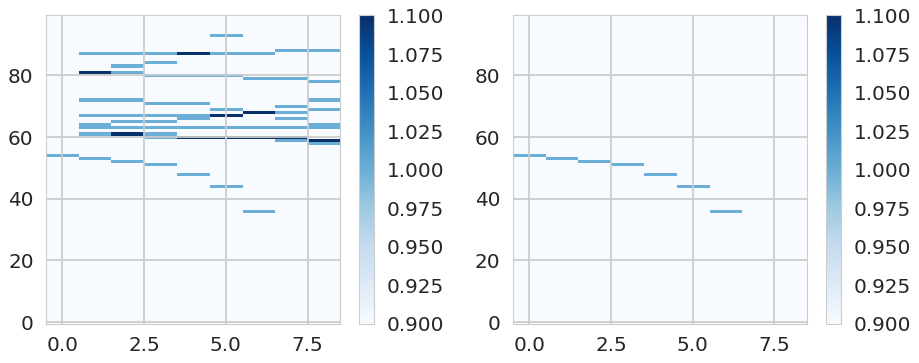

In [48]:
# Plot an example training and target sample 
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
im = plt.imshow(np.sum(train_input[10],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower', vmin=1, vmax=1, cmap='Blues')
plt.colorbar(im)
plt.subplot(1,2,2)
t_im = plt.imshow(np.sum(train_target[10],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower', vmin=1, vmax=1, cmap='Blues')
plt.colorbar(t_im)
plt.tight_layout()

In [12]:
import keras
from keras.layers import Input, Dense, LSTM, TimeDistributed, Reshape
from keras.models import Model

def build_model(num_hidden, length, dim1, dim2,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = Input(shape=(length, dim1, dim2),name='inputs')
    reshape = Reshape((length, dim1*dim2),name='reshape_inputs')(inputs)
    hidden = LSTM(units=num_hidden, return_sequences=True,name='lstm')(reshape)
    dense = TimeDistributed(Dense(dim1*dim2, activation='softmax'),name='dense')(hidden)
    outputs = Reshape((length, dim1, dim2),name='reshape_outputs')(dense)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

def build_model_2d(num_hidden, length, dim1,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = Input(shape=(length, dim1),name='inputs')
    hidden = LSTM(units=num_hidden, return_sequences=True,name='lstm')(inputs)
    outputs = TimeDistributed(Dense(dim1, activation='softmax'),name='dense')(hidden)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Using TensorFlow backend.


In [18]:
# Split train and validation sets
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(train_input, train_target, 
                                                                        test_size=0.2, random_state=42)

X_train_val_2d, X_test_2d, y_train_val_2d, y_test_2d = train_test_split(train_input_2d, train_target_2d, 
                                                                        test_size=0.2, random_state=42)    

In [19]:
print('Starting 3d training...')
model = build_model(150, r_bins, phi_bins, z_bins)
model.summary()
history = model.fit(X_train_val, y_train_val, batch_size=128, 
                    validation_split = 0.25, shuffle = True, epochs=100)

Starting training...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 9, 100, 100)       0         
_________________________________________________________________
reshape_inputs (Reshape)     (None, 9, 10000)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 9, 150)            6090600   
_________________________________________________________________
dense (TimeDistributed)      (None, 9, 10000)          1510000   
_________________________________________________________________
reshape_outputs (Reshape)    (None, 9, 100, 100)       0         
Total params: 7,600,600
Trainable params: 7,600,600
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape    

Epoch 48/100
1089/1089 [==============================] - 4s 4ms/step - loss: 0.0053 - acc: 0.0086 - val_loss: 0.0349 - val_acc: 0.0040
Epoch 49/100
1089/1089 [==============================] - 4s 4ms/step - loss: 0.0051 - acc: 0.0086 - val_loss: 0.0349 - val_acc: 0.0041
Epoch 50/100
1089/1089 [==============================] - 4s 4ms/step - loss: 0.0049 - acc: 0.0087 - val_loss: 0.0350 - val_acc: 0.0041
Epoch 51/100
1089/1089 [==============================] - 4s 4ms/step - loss: 0.0047 - acc: 0.0087 - val_loss: 0.0350 - val_acc: 0.0041
Epoch 52/100
1089/1089 [==============================] - 4s 4ms/step - loss: 0.0045 - acc: 0.0087 - val_loss: 0.0351 - val_acc: 0.0041
Epoch 53/100
1089/1089 [==============================] - 4s 4ms/step - loss: 0.0044 - acc: 0.0087 - val_loss: 0.0351 - val_acc: 0.0041
Epoch 54/100
1089/1089 [==============================] - 4s 4ms/step - loss: 0.0043 - acc: 0.0087 - val_loss: 0.0351 - val_acc: 0.0041
Epoch 55/100
1089/1089 [========================

Epoch 8/100
1089/1089 [==============================] - 0s 163us/step - loss: 3.5388 - acc: 0.2246 - val_loss: 3.8523 - val_acc: 0.1751
Epoch 9/100
1089/1089 [==============================] - 0s 162us/step - loss: 3.4400 - acc: 0.2401 - val_loss: 3.8039 - val_acc: 0.1827
Epoch 10/100
1089/1089 [==============================] - 0s 160us/step - loss: 3.3533 - acc: 0.2567 - val_loss: 3.7684 - val_acc: 0.1879
Epoch 11/100
1089/1089 [==============================] - 0s 162us/step - loss: 3.2721 - acc: 0.2714 - val_loss: 3.7418 - val_acc: 0.1928
Epoch 12/100
1089/1089 [==============================] - 0s 161us/step - loss: 3.1983 - acc: 0.2853 - val_loss: 3.7053 - val_acc: 0.2026
Epoch 13/100
1089/1089 [==============================] - 0s 163us/step - loss: 3.1300 - acc: 0.2922 - val_loss: 3.6691 - val_acc: 0.2032
Epoch 14/100
1089/1089 [==============================] - 0s 162us/step - loss: 3.0672 - acc: 0.3032 - val_loss: 3.6412 - val_acc: 0.2094
Epoch 15/100
1089/1089 [============

1089/1089 [==============================] - 0s 162us/step - loss: 1.2757 - acc: 0.6653 - val_loss: 2.7222 - val_acc: 0.4068
Epoch 68/100
1089/1089 [==============================] - 0s 162us/step - loss: 1.2636 - acc: 0.6664 - val_loss: 2.7133 - val_acc: 0.4080
Epoch 69/100
1089/1089 [==============================] - 0s 160us/step - loss: 1.2383 - acc: 0.6733 - val_loss: 2.6955 - val_acc: 0.4129
Epoch 70/100
1089/1089 [==============================] - 0s 159us/step - loss: 1.2223 - acc: 0.6744 - val_loss: 2.6847 - val_acc: 0.4132
Epoch 71/100
1089/1089 [==============================] - 0s 162us/step - loss: 1.2029 - acc: 0.6783 - val_loss: 2.6804 - val_acc: 0.4123
Epoch 72/100
1089/1089 [==============================] - 0s 160us/step - loss: 1.1862 - acc: 0.6837 - val_loss: 2.6717 - val_acc: 0.4148
Epoch 73/100
1089/1089 [==============================] - 0s 161us/step - loss: 1.1672 - acc: 0.6876 - val_loss: 2.6636 - val_acc: 0.4206
Epoch 74/100
1089/1089 [=======================

In [40]:
print('Starting 2d training...')
model_2d = build_model_2d(50, r_bins, phi_bins)
model_2d.summary()
history = model_2d.fit(X_train_val_2d, y_train_val_2d, batch_size=128, 
                       validation_split = 0.25, shuffle = True, epochs=500)

Starting 2d training...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 9, 100)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 9, 50)             30200     
_________________________________________________________________
dense (TimeDistributed)      (None, 9, 100)            5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________
Train on 1089 samples, validate on 363 samples
Epoch 1/500
1089/1089 [==============================] - 1s 633us/step - loss: 4.2435 - acc: 0.0205 - val_loss: 4.2861 - val_acc: 0.0352
Epoch 2/500
1089/1089 [==============================] - 0s 184us/step - loss: 4.2004 - acc: 0.0735 - val_loss: 4.2493 - val_acc: 0.0817
Epoch 3/500
1089/1089 [==============================] - 

1089/1089 [==============================] - 0s 173us/step - loss: 1.5442 - acc: 0.6128 - val_loss: 2.8901 - val_acc: 0.3548
Epoch 55/500
1089/1089 [==============================] - 0s 173us/step - loss: 1.5220 - acc: 0.6200 - val_loss: 2.8738 - val_acc: 0.3569
Epoch 56/500
1089/1089 [==============================] - 0s 171us/step - loss: 1.5032 - acc: 0.6209 - val_loss: 2.8552 - val_acc: 0.3581
Epoch 57/500
1089/1089 [==============================] - 0s 183us/step - loss: 1.4803 - acc: 0.6254 - val_loss: 2.8580 - val_acc: 0.3594
Epoch 58/500
1089/1089 [==============================] - 0s 171us/step - loss: 1.4586 - acc: 0.6310 - val_loss: 2.8417 - val_acc: 0.3646
Epoch 59/500
1089/1089 [==============================] - 0s 173us/step - loss: 1.4418 - acc: 0.6319 - val_loss: 2.8338 - val_acc: 0.3670
Epoch 60/500
1089/1089 [==============================] - 0s 171us/step - loss: 1.4225 - acc: 0.6365 - val_loss: 2.8173 - val_acc: 0.3691
Epoch 61/500
1089/1089 [=======================

1089/1089 [==============================] - 0s 172us/step - loss: 0.6490 - acc: 0.7852 - val_loss: 2.4841 - val_acc: 0.4634
Epoch 114/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.6390 - acc: 0.7888 - val_loss: 2.4859 - val_acc: 0.4650
Epoch 115/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.6305 - acc: 0.7893 - val_loss: 2.4834 - val_acc: 0.4640
Epoch 116/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.6213 - acc: 0.7922 - val_loss: 2.4844 - val_acc: 0.4674
Epoch 117/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.6110 - acc: 0.7954 - val_loss: 2.4809 - val_acc: 0.4702
Epoch 118/500
1089/1089 [==============================] - 0s 174us/step - loss: 0.6021 - acc: 0.7976 - val_loss: 2.4783 - val_acc: 0.4686
Epoch 119/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.5945 - acc: 0.7969 - val_loss: 2.4783 - val_acc: 0.4680
Epoch 120/500
1089/1089 [================

1089/1089 [==============================] - 0s 170us/step - loss: 0.3100 - acc: 0.8570 - val_loss: 2.5231 - val_acc: 0.4949
Epoch 173/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.3078 - acc: 0.8569 - val_loss: 2.5307 - val_acc: 0.4904
Epoch 174/500
1089/1089 [==============================] - 0s 170us/step - loss: 0.3106 - acc: 0.8545 - val_loss: 2.5267 - val_acc: 0.4928
Epoch 175/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.3043 - acc: 0.8562 - val_loss: 2.5347 - val_acc: 0.4897
Epoch 176/500
1089/1089 [==============================] - 0s 170us/step - loss: 0.3022 - acc: 0.8573 - val_loss: 2.5285 - val_acc: 0.4925
Epoch 177/500
1089/1089 [==============================] - 0s 174us/step - loss: 0.2969 - acc: 0.8581 - val_loss: 2.5389 - val_acc: 0.4928
Epoch 178/500
1089/1089 [==============================] - 0s 170us/step - loss: 0.2940 - acc: 0.8592 - val_loss: 2.5387 - val_acc: 0.4953
Epoch 179/500
1089/1089 [================

1089/1089 [==============================] - 0s 171us/step - loss: 0.1812 - acc: 0.8780 - val_loss: 2.6847 - val_acc: 0.4943
Epoch 232/500
1089/1089 [==============================] - 0s 170us/step - loss: 0.1791 - acc: 0.8791 - val_loss: 2.6914 - val_acc: 0.4940
Epoch 233/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.1788 - acc: 0.8789 - val_loss: 2.6883 - val_acc: 0.4919
Epoch 234/500
1089/1089 [==============================] - 0s 173us/step - loss: 0.1773 - acc: 0.8801 - val_loss: 2.6949 - val_acc: 0.4937
Epoch 235/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.1760 - acc: 0.8781 - val_loss: 2.6926 - val_acc: 0.4925
Epoch 236/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.1741 - acc: 0.8797 - val_loss: 2.6997 - val_acc: 0.4934
Epoch 237/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.1729 - acc: 0.8801 - val_loss: 2.6984 - val_acc: 0.4940
Epoch 238/500
1089/1089 [================

1089/1089 [==============================] - 0s 172us/step - loss: 0.1284 - acc: 0.8782 - val_loss: 2.8242 - val_acc: 0.4989
Epoch 291/500
1089/1089 [==============================] - 0s 174us/step - loss: 0.1272 - acc: 0.8811 - val_loss: 2.8349 - val_acc: 0.4977
Epoch 292/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.1268 - acc: 0.8786 - val_loss: 2.8267 - val_acc: 0.5008
Epoch 293/500
1089/1089 [==============================] - 0s 170us/step - loss: 0.1258 - acc: 0.8796 - val_loss: 2.8360 - val_acc: 0.4989
Epoch 294/500
1089/1089 [==============================] - 0s 170us/step - loss: 0.1250 - acc: 0.8804 - val_loss: 2.8353 - val_acc: 0.4980
Epoch 295/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.1250 - acc: 0.8808 - val_loss: 2.8401 - val_acc: 0.5008
Epoch 296/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.1245 - acc: 0.8802 - val_loss: 2.8409 - val_acc: 0.5011
Epoch 297/500
1089/1089 [================

1089/1089 [==============================] - 0s 172us/step - loss: 0.1148 - acc: 0.8785 - val_loss: 2.9571 - val_acc: 0.4992
Epoch 350/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.1466 - acc: 0.8696 - val_loss: 2.9583 - val_acc: 0.4971
Epoch 351/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.1755 - acc: 0.8658 - val_loss: 2.9443 - val_acc: 0.4989
Epoch 352/500
1089/1089 [==============================] - 0s 173us/step - loss: 0.1795 - acc: 0.8660 - val_loss: 2.9259 - val_acc: 0.4983
Epoch 353/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.1613 - acc: 0.8724 - val_loss: 2.8996 - val_acc: 0.5017
Epoch 354/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.1457 - acc: 0.8732 - val_loss: 2.9373 - val_acc: 0.5054
Epoch 355/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.1357 - acc: 0.8774 - val_loss: 2.9398 - val_acc: 0.5029
Epoch 356/500
1089/1089 [================

1089/1089 [==============================] - 0s 171us/step - loss: 0.0877 - acc: 0.8794 - val_loss: 3.0329 - val_acc: 0.5014
Epoch 409/500
1089/1089 [==============================] - 0s 170us/step - loss: 0.0875 - acc: 0.8774 - val_loss: 3.0296 - val_acc: 0.5057
Epoch 410/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.0877 - acc: 0.8786 - val_loss: 3.0322 - val_acc: 0.5060
Epoch 411/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.0881 - acc: 0.8778 - val_loss: 3.0413 - val_acc: 0.5051
Epoch 412/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.0871 - acc: 0.8794 - val_loss: 3.0362 - val_acc: 0.5047
Epoch 413/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.0875 - acc: 0.8792 - val_loss: 3.0419 - val_acc: 0.5017
Epoch 414/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.0872 - acc: 0.8797 - val_loss: 3.0427 - val_acc: 0.5041
Epoch 415/500
1089/1089 [================

1089/1089 [==============================] - 0s 171us/step - loss: 0.0796 - acc: 0.8788 - val_loss: 3.1135 - val_acc: 0.5047
Epoch 468/500
1089/1089 [==============================] - 0s 173us/step - loss: 0.0794 - acc: 0.8783 - val_loss: 3.1154 - val_acc: 0.5051
Epoch 469/500
1089/1089 [==============================] - 0s 170us/step - loss: 0.0795 - acc: 0.8811 - val_loss: 3.1166 - val_acc: 0.5020
Epoch 470/500
1089/1089 [==============================] - 0s 172us/step - loss: 0.0799 - acc: 0.8788 - val_loss: 3.1166 - val_acc: 0.5017
Epoch 471/500
1089/1089 [==============================] - 0s 170us/step - loss: 0.0798 - acc: 0.8797 - val_loss: 3.1207 - val_acc: 0.5041
Epoch 472/500
1089/1089 [==============================] - 0s 173us/step - loss: 0.0790 - acc: 0.8799 - val_loss: 3.1268 - val_acc: 0.5023
Epoch 473/500
1089/1089 [==============================] - 0s 171us/step - loss: 0.0792 - acc: 0.8798 - val_loss: 3.1290 - val_acc: 0.4992
Epoch 474/500
1089/1089 [================

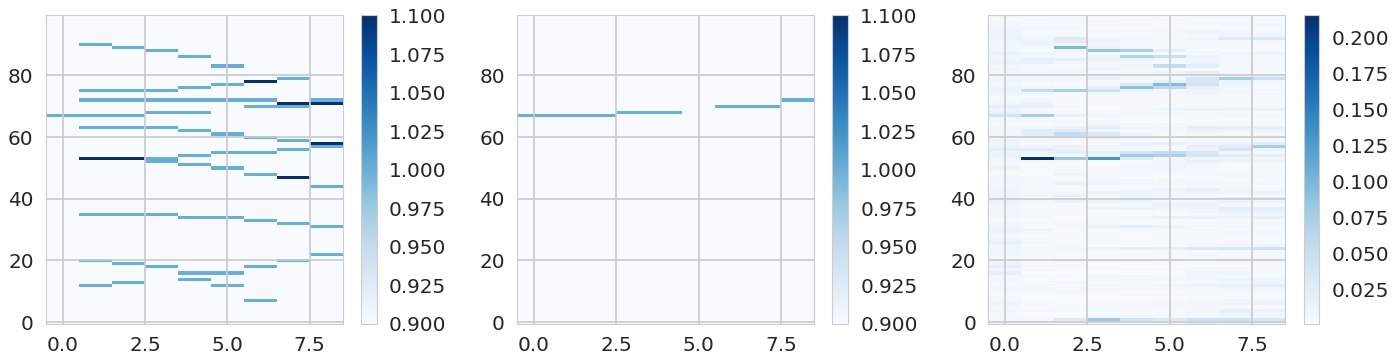

In [44]:
# 3d model input, target, and prediction
ii = 17 # sample number
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
im = plt.imshow(np.sum(X_test[ii],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower', vmin=1, vmax=1, cmap='Blues')
plt.colorbar(im)
plt.subplot(1,3,2)
t_im = plt.imshow(np.sum(y_test[ii],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower',vmin=1, vmax=1, cmap='Blues')
plt.colorbar(t_im)
plt.subplot(1,3,3)
predict = model.predict(X_test[ii:ii+1,:,:,:])
p_im = plt.imshow(np.sum(predict[0],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower', cmap='Blues')
plt.colorbar(p_im)
plt.tight_layout()

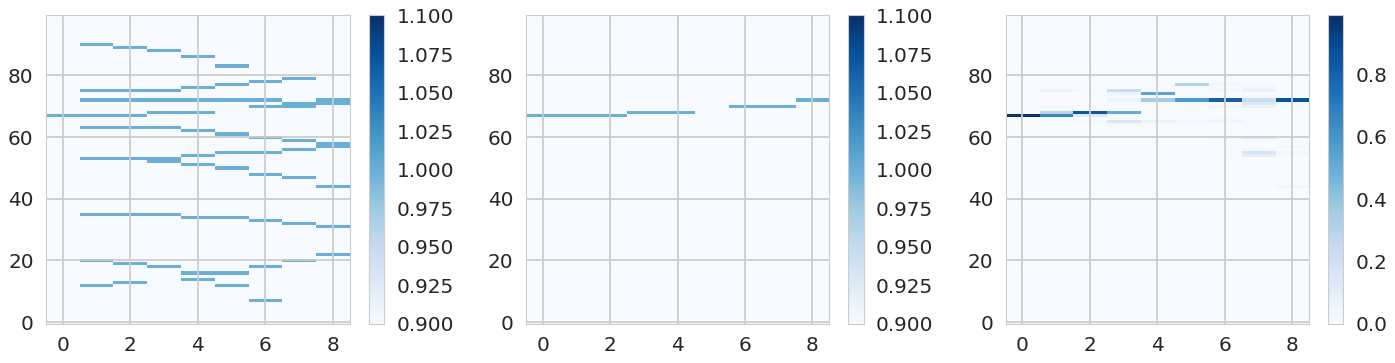

In [45]:
# 2d model input, target, and prediction
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
im = plt.imshow(X_test_2d[ii].T, interpolation='none',
               aspect='auto', origin='lower', vmin=1, vmax=1, cmap='Blues')
plt.colorbar(im)
plt.subplot(1,3,2)
t_im = plt.imshow(y_test_2d[ii].T, interpolation='none',
               aspect='auto', origin='lower',vmin=1, vmax=1, cmap='Blues')
plt.colorbar(t_im)
plt.subplot(1,3,3)
predict = model_2d.predict(X_test_2d[ii:ii+1,:,:])
p_im = plt.imshow(predict[0].T, interpolation='none',
               aspect='auto', origin='lower', cmap='Blues')
plt.colorbar(p_im)
plt.tight_layout()